In [20]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as F2
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import random
import glob
from collections import Counter
from PIL import Image
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve
from monai.networks.nets import DenseNet169 #, HighResNet, EfficientNet, ResNet
import cv2
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import regionprops, label
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import sobel
from scipy.stats import skew, kurtosis
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import MinMaxScaler


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_DIR = r"C:\Users\mm17b2k.DS\DataspellProjects\MICCAI\Mycetoma Dataset"


# Get the paths
train_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/training_dataset/**/*')])
val_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/validation_dataset/**/*')])
test_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/test_dataset/**/*')])

#post processing binary 
train_seg_paths_bin = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/binary postprocessed/corrected_masks_and_augmented_postproc_training/**/*')])
val_seg_paths_bin = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/binary postprocessed/corrected_masks_and_augmented_postproc_validation/**/*')])


#post processing logit
train_seg_paths_log = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/logit output/corrected_masks_and_augmented_training/**/*')])
val_seg_paths_log = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/logit output/corrected_masks_and_augmented_validation/**/*')])

# multitask binary
train_seg_paths_multibin = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/multitask/binary postprocessed/multitask_postproc_training/**/*')])
val_seg_paths_multibin = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/multitask/binary postprocessed/multitask_postproc_validation/**/*')])
test_seg_paths_multibin = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/multitask/binary postprocessed/multitask_postproc_test/*')])#



# multitask logit
train_seg_paths_multilog = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/multitask/logit output/multitask_training/**/*')])
val_seg_paths_multilog = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/multitask/logit output/multitask_validation/**/*')])

# best final 
train_seg_paths_multibin = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/Best_final_masks\Best_model_training/**/*')])
val_seg_paths_multibin = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/Best_final_masks\Best_model_validation/**/*')])
test_seg_paths_multibin = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/Best_final_masks\Best_model_test/*')])


# remove any with mask in it
train_img_paths = train_paths[[not 'mask' in i for i in train_paths]]
val_img_paths = val_paths[[not 'mask' in i for i in val_paths]]
img_paths = [train_img_paths, val_img_paths]

def format_file_paths(paths, img_paths):
    file_paths = []
    patient = []
    for file in img_paths:
        patient.append(file)
        matched = False
        #file_start = '.'.join(file.split('.')[:-1])
        file_end = file.split("\\")[-1].split('.')[0]
        for file2 in paths:
            if 'mask' in file2:
                #file_start2 = '.'.join(file2.split('.')[:-1])[:-5]
                file_end2 = '_'.join(file2.split("\\")[-1].split('.')[0].split('_')[0:2])
                if file_end == file_end2:
                    patient.append(file2)
                    file_paths.append(patient)
                    patient = []
                    matched = True
        if matched == False:
            print(f"Could not find mask for {file_end}")
    return file_paths

train_paths = format_file_paths(train_seg_paths_multibin, train_img_paths)
val_paths = format_file_paths(val_seg_paths_multibin, val_img_paths)


def format_test_file_paths(paths, img_paths):
    file_paths = []
    patient = []
    for file in img_paths:
        patient.append(file)
        matched = False
        #file_start = '.'.join(file.split('.')[:-1])
        file_end = file.split("\\")[-1].split('.')[0]
        for file2 in paths:
            if 'mask' in file2:
                #file_start2 = '.'.join(file2.split('.')[:-1])[:-5]
                file_end2 = '_'.join(file2.split("\\")[-1].split('.')[0].split('_')[0:1])
                if file_end == file_end2:
                    patient.append(file2)
                    file_paths.append(patient)
                    patient = []
                    matched = True
        if matched == False:
            print(f"Could not find mask for {file_end}")
    return file_paths
test_paths = format_test_file_paths(test_seg_paths_multibin, test_paths)




print(f"Train length: {len(train_paths)}")
print(f"Val length: {len(val_paths)}")
print(f"Test length: {len(test_paths)}")




Train length: 593
Val length: 91
Test length: 167


In [21]:
# Extract clinical features from the image and mask

def summarise_histogram(histogram):
    # Compute basic statistics
    mean = np.mean(histogram)
    variance = np.var(histogram)
    skewness = skew(histogram)
    kurt = kurtosis(histogram)

    # Combine statistics into a summary vector
    summary_vector = np.array([mean, variance, skewness, kurt])
    return summary_vector

# Extract texture features using GLCM
def extract_glcm_features(image):
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    return np.array([contrast, homogeneity, energy])

# Extract Local Binary Patterns (LBP) features
def extract_lbp_features(image):
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= lbp_hist.sum()  # Normalize histogram
    summary_lbp_hist = summarise_histogram(lbp_hist)
    return summary_lbp_hist

# Extract morphological features from segmentation mask
def extract_morphological_features(mask):
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)
    if len(regions) == 0:
        return 0, 0, 0, 0
        #return {'area': 0, 'perimeter': 0, 'eccentricity': 0, 'solidity': 0}

    # Taking properties of the first detected region
    region = regions[0]
    area = region.area
    perimeter = region.perimeter
    eccentricity = region.eccentricity
    solidity = region.solidity
    return np.array([area, perimeter, eccentricity, solidity])

# Extract color features
def extract_colour_features(image):
    mean = np.mean(image, axis=(0, 1))
    variance = np.var(image, axis=(0, 1))
    skewness = np.mean((image - mean) ** 3, axis=(0, 1)) / variance ** (3/2)
    colour_features = (mean, variance, skewness)
    colour_features = np.concatenate(colour_features)

    return colour_features

# Edge features using Sobel
def extract_edge_features(image):
    edges = sobel(image)
    edge_hist = np.histogram(edges, bins=256)[0]
    summary_edge_hist = summarise_histogram(edge_hist)
    #edge_density = np.sum(edges) / (image.shape[0] * image.shape[1])
    #edge_features = np.concatenate([summary_edge_hist, np.array([edge_density])])
    return summary_edge_hist


# Calculate Dice score using the formula
def calculate_border_irregualirty(mask):
    mask = mask.astype(np.float32)
    # Apply Gaussian smoothing with a specified sigma
    sigma = 12.0
    smoothed_mask = gaussian_filter(mask, sigma=sigma)
    binary_smoothed_mask = (smoothed_mask >= 0.5).astype(np.uint8)
    intersection = np.sum(mask * binary_smoothed_mask)
    dice = (2 * intersection) / (np.sum(mask) + np.sum(binary_smoothed_mask))
    return np.array([dice])


def calculate_perimeter(mask):
    # Ensure the mask is a binary mask (0 and 1)
    mask = (mask > 0)

    # Convert binary mask to uint8 (required by Canny edge detector)
    mask_uint8 = (mask * 255).astype(np.uint8)

    # Apply Canny edge detector
    edges = cv2.Canny(mask_uint8, 100, 200)  # Adjust thresholds as needed

    # Count non-zero edge pixels to get the perimeter
    perimeter = np.sum(edges > 0)

    return perimeter

def calculate_area(mask):
    # Simply count the number of pixels within the mask (where mask is 1)
    area = mask.sum()
    return area.item()

def calculate_border_metrics(mask):
    perimeter = calculate_perimeter(mask)
    area = calculate_area(mask)
    # print(perimeter, area)
    # print(mask.dtype)

    # Compute circularity and border irregularity index 
    circularity = (4 * torch.pi * area) / (perimeter ** 2)

    BII = perimeter / np.sqrt(4 * np.pi * area)
    # if na
    if np.isnan(BII):
        BII = 0
    if np.isnan(circularity):
        circularity = 0
    return np.array([circularity, BII])


def extract_features(image_path, mask_path):
    image_np = np.asarray(Image.open(image_path))
    segmentation_mask = np.asarray(Image.open(mask_path))

    gray_image = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    masked_image = cv2.bitwise_and(gray_image, gray_image, mask=segmentation_mask.astype(np.uint8))

    texture_features = extract_glcm_features(masked_image)
    lbp_features = extract_lbp_features(masked_image)
    morphological_features = extract_morphological_features(segmentation_mask)
    colour_features = extract_colour_features(image_np)
    edge_features = extract_edge_features(masked_image)
    border_irregularity = calculate_border_irregualirty(segmentation_mask)
    border_metrics = calculate_border_metrics(segmentation_mask)

    feature_vector = np.concatenate([
        texture_features,
        lbp_features,
        morphological_features,
        colour_features,
        edge_features,
        border_irregularity,
        border_metrics
    ])

    return feature_vector

first_time = True
if first_time:
    features_list = []
    for image_path, mask_path in train_paths:
        feature_vector = extract_features(image_path, mask_path)
        features_list.append(feature_vector)


    hand_crafted_features_df = pd.DataFrame(features_list, columns=[
        'contrast', 'homogeneity', 'energy', 'lbp1', 'lbp2', 'lbp3', 'lbp4',
        'area', 'perimeter', 'eccentricity', 'solidity', 'mean_R', 'mean_G', 'mean_B',
        'variance_R', 'variance_G', 'variance_B', 'skewness_R', 'skewness_G', 'skewness_B',
        'edge_hist_0', 'edge_hist_1', 'edge_hist_2', 'edge_hist_3',
        'border_irregularity', 'circularity', 'BII'])

    # Normalize features
    scaler = MinMaxScaler()
    df_normalised = pd.DataFrame(scaler.fit_transform(hand_crafted_features_df), columns=hand_crafted_features_df.columns)
    # replace negatives and smaller than 1e-3 with 0
    df_normalised[df_normalised < 0] = 0
    df_normalised[df_normalised < 1e-3] = 0

    # Save to CSV
    df_normalised.to_csv('features_normalised.csv', index=False)

    print("Normalised features saved to 'features_normalised.csv'")


    val_features_list = []
    for image_path, mask_path in val_paths:
        feature_vector = extract_features(image_path, mask_path)
        val_features_list.append(feature_vector)

    val_hand_crafted_features_df = pd.DataFrame(val_features_list, columns=[
        'contrast', 'homogeneity', 'energy', 'lbp1', 'lbp2', 'lbp3', 'lbp4',
        'area', 'perimeter', 'eccentricity', 'solidity', 'mean_R', 'mean_G', 'mean_B',
        'variance_R', 'variance_G', 'variance_B', 'skewness_R', 'skewness_G', 'skewness_B',
        'edge_hist_0', 'edge_hist_1', 'edge_hist_2', 'edge_hist_3',
        'border_irregularity', 'circularity', 'BII'])

    test_features_list = []
    for image_path, mask_path in test_paths:
        feature_vector = extract_features(image_path, mask_path)
        test_features_list.append(feature_vector)
    
    test_hand_crafted_features_df = pd.DataFrame(test_features_list, columns=[
        'contrast', 'homogeneity', 'energy', 'lbp1', 'lbp2', 'lbp3', 'lbp4',
        'area', 'perimeter', 'eccentricity', 'solidity', 'mean_R', 'mean_G', 'mean_B',
        'variance_R', 'variance_G', 'variance_B', 'skewness_R', 'skewness_G', 'skewness_B',
        'edge_hist_0', 'edge_hist_1', 'edge_hist_2', 'edge_hist_3',
        'border_irregularity', 'circularity', 'BII'])

    # To normalise test data, use the same scaler
    def normalise_features(features, scaler):
        return pd.DataFrame(scaler.transform(features), columns=hand_crafted_features_df.columns)

    # Normalise validation and test data
    df_val_normalised = normalise_features(val_hand_crafted_features_df, scaler)
    df_test_normalised = normalise_features(test_hand_crafted_features_df, scaler)
    
    # make negatives 0
    df_val_normalised[df_val_normalised < 0] = 0
    df_test_normalised[df_test_normalised < 0] = 0
    
    # replace na with 0
    df_val_normalised.fillna(0, inplace=True)
    df_test_normalised.fillna(0, inplace=True)
    
    # if less than 1e-3, make 0
    df_val_normalised[df_val_normalised < 1e-3] = 0
    df_test_normalised[df_test_normalised < 1e-3] = 0

    # Save normalised data to CSV
    df_val_normalised.to_csv('val_features_normalised.csv', index=False)
    df_test_normalised.to_csv('test_features_normalised.csv', index=False)


hand_crafted_features_df = pd.read_csv('features_normalised.csv')
hand_crafted_features_val_df = pd.read_csv('val_features_normalised.csv')
hand_crafted_features_test_df = pd.read_csv('test_features_normalised.csv')

Normalised features saved to 'features_normalised.csv'


C:\Users\mm17b2k.DS\AppData\Local\Temp\ipykernel_18020\1303288964.py:77: RuntimeWarning: invalid value encountered in scalar divide
  dice = (2 * intersection) / (np.sum(mask) + np.sum(binary_smoothed_mask))
C:\Users\mm17b2k.DS\AppData\Local\Temp\ipykernel_18020\1303288964.py:108: RuntimeWarning: invalid value encountered in scalar divide
  circularity = (4 * torch.pi * area) / (perimeter ** 2)
C:\Users\mm17b2k.DS\AppData\Local\Temp\ipykernel_18020\1303288964.py:110: RuntimeWarning: invalid value encountered in scalar divide
  BII = perimeter / np.sqrt(4 * np.pi * area)


In [22]:
def clip_and_norm(image, upper_bound):
    # Clip intensity values
    image = np.clip(image, 0, upper_bound)

    # Normalize the image to the range [0, 1]
    norm = (image - 0) / (upper_bound - 0)
    # minmax scaling
    #norm = (image - np.min(image)) / (np.max(image) - np.min(image))

    return norm

# MAKE DATASET CLASS

# Define the 3D Dataset class
# Image and mask both need same transforms to be applied, so DO NOT USE RANDOM TRANSFORMS
# - use e.g. transforms.functional.hflip which has no randomness.
class MycetomaDataset(Dataset):
    def __init__(self, paths, data_dir, hand_crafted_features_df=None, mask_channel=False, transform=None, transform_chance=0.5, test=False):
        self.paths = paths
        self.data_dir = data_dir
        self.transform = transform
        self.transform_chance = transform_chance
        self.mask_channel = mask_channel
        self.hand_crafted_features_df = hand_crafted_features_df
        self.test = test

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        if self.test == True:
            image_path = self.paths[index]
            mask_path = None
        else:
            image_path = self.paths[index][0]
            mask_path = self.paths[index][1]

        if self.mask_channel == True:
            image_path = self.paths[index][0]
            mask_path = self.paths[index][1]
    
            # Load the image and mask
            mask = np.asarray(Image.open(mask_path))
            # if mask more than one channel, turn to 2d by taking first channel
            if len(mask.shape) > 2:
                mask = mask[..., 0]
    
            # clip mask
            # assert mask.max() == 1, "Mask must be binary"
    
            mask = torch.from_numpy(mask).float().unsqueeze(0)
    
        image = np.asarray(Image.open(image_path))
            

        if 'BM' in image_path:
            label = 0
        if 'FM' in image_path:
            label = 1

        # Check image and mask size
        assert image.shape == (600, 800, 3), "Image size must be (600, 800, 3)"

        # normalise image
        image = clip_and_norm(image, 255)

        # turn to torch, permute image to move channel to front, and return
        image = torch.from_numpy(image).float().permute(2,0,1)


        if self.transform != None:
            transform1 = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
            ])
            transform2 = transforms.Compose([
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02)
            ])

            if self.mask_channel == True:
                image, mask = transform1(image, mask)
                
            if self.mask_channel == False:
                image = transform1(image)
                
            image = transform2(image)

        if self.mask_channel:
            image = torch.cat((image, mask), dim=0)

        if self.hand_crafted_features_df is not None:
            hand_crafted_features = self.hand_crafted_features_df.iloc[index].values
        else:
            hand_crafted_features = np.zeros(28)
        
        if self.test == True:
            return image, hand_crafted_features
    
        return image, hand_crafted_features, label
 



# train_paths = format_file_paths(train_seg_paths_multibin, train_img_paths)
# val_paths = format_file_paths(val_seg_paths_multibin, val_img_paths)
# 
# train_dataset = MycetomaDataset(train_paths, DATA_DIR, hand_crafted_features_df, mask_channel=True, transform=True)
# val_dataset = MycetomaDataset(val_paths, DATA_DIR, hand_crafted_features_val_df,  mask_channel=True)
# # MAKE DATALOADER
# train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# should we combine validation data with training data and train on it all with the best hyperparams?

In [23]:
class CustomDenseNet(nn.Module):
    def __init__(self, in_channels, num_handcrafted_features, num_classes=1):
        super(CustomDenseNet, self).__init__()

        # Load pre-trained DenseNet model
        self.model = DenseNet169(spatial_dims=2,
                                 in_channels=in_channels,
                                 out_channels=1,
                                 pretrained=True)


        # Remove the final classifier layer
        num_features = self.model.features[-1].num_features
        self.model.class_layers.out = nn.Identity()

        # New classifier combining DenseNet features and hand-crafted features
        self.fc1 = nn.Linear(num_features + num_handcrafted_features, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x, handcrafted_features):
        # Extract features from DenseNet
        dense_features = self.model(x)

        # Concatenate DenseNet features with hand-crafted features
        combined_features = torch.cat((dense_features, handcrafted_features), dim=1)

        # Pass through the final classifier
        x = self.fc1(combined_features)
        x = nn.ReLU()(x)
        x = self.fc2(x)

        return x

In [39]:
def train_model(hyperparams):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get the image paths
    DATA_DIR = r"C:\Users\mm17b2k.DS\DataspellProjects\MICCAI\Mycetoma Dataset"
    train_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/training_dataset/**/*')])
    val_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/validation_dataset/**/*')])
    # remove any with mask in it
    train_img_paths = train_paths[[not 'mask' in i for i in train_paths]]
    val_img_paths = val_paths[[not 'mask' in i for i in val_paths]]

    num_epochs = 30
    lr = hyperparams["lr"]
    batch_size = hyperparams["batch_size"]
    weight_decay = hyperparams["weight_decay"]
    mask_channel = hyperparams["mask_channel"]
    threshold = hyperparams["threshold"]
    use_handcrafted = True

    if mask_channel:
        num_channels = 4
    else:
        num_channels = 3

    seg_path_type = hyperparams["seg_path"]
    seg_paths = ["binary postprocessed/corrected_masks_and_augmented_postproc",
                 "logit output/corrected_masks_and_augmented",
                 "multitask/binary postprocessed/multitask_postproc",
                 "multitask/logit output/multitask",
                 "Best_final_masks\Best_model"]
    seg_path_end = seg_paths[seg_path_type]

    train_seg_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/{seg_path_end}_training/**/*')])
    val_seg_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/{seg_path_end}_validation/**/*')])


    train_paths = format_file_paths(train_seg_paths, train_img_paths)
    val_paths = format_file_paths(val_seg_paths, val_img_paths)

    if use_handcrafted:
        hand_crafted_features_df = pd.read_csv('features_normalised.csv')
        hand_crafted_features_val_df = pd.read_csv('val_features_normalised.csv')
    if use_handcrafted == False:
        hand_crafted_features_df = None
        hand_crafted_features_val_df = None
        
    train_dataset = MycetomaDataset(train_paths, DATA_DIR, hand_crafted_features_df, mask_channel=mask_channel, transform=True)
    val_dataset = MycetomaDataset(val_paths, DATA_DIR, hand_crafted_features_val_df, mask_channel=mask_channel)
    
    # MAKE DATALOADER
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

    if use_handcrafted:
        num_handcrafted_features = 27  # Update according to your features
        model = CustomDenseNet(in_channels=num_channels,    num_handcrafted_features=num_handcrafted_features)
    if use_handcrafted == False:
        model = DenseNet169(
            spatial_dims=2,
            in_channels=num_channels,
            out_channels=1,
            pretrained=True)

    model = model.to(device)
    
    print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    criterion = nn.BCEWithLogitsLoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, verbose=True,
                                                              threshold=0.01, threshold_mode='abs')

    train_losses, test_losses = [], []
    accumulation_steps = 3
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        all_train_labels = []
        all_train_preds = []
        steps = 0
        optimiser.zero_grad()


        for features, hand_crafted_features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            hand_crafted_features = hand_crafted_features.to(device)
            steps += 1
            # Forward pass
            #optimizer.zero_grad()
            if use_handcrafted:
                output = model(features, hand_crafted_features.float())  # Remove batch dimension
            else:
                output = model(features)
                
            output = output.squeeze(1)
            loss = criterion(output, labels.float())
            train_loss += loss.item()

            # # Backward pass and optimization
            # loss.backward()
            # optimizer.step()
            # Backward pass and optimization
            loss.backward()
            if steps % accumulation_steps == 1:
                optimiser.step()
                optimiser.zero_grad()

            # Apply threshold to determine predicted class
            #predicted_probs = F.softmax(output, dim=1)[:, 1]  # Probability of class 1 (positive)
            predicted_probs = torch.sigmoid(output)
            predicted_class = (predicted_probs >= threshold).long()

            # Store predictions and labels
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted_class.cpu().numpy())

        optimiser.step()
        optimiser.zero_grad()
        lr_scheduler.step(train_loss/len(train_loader))
        print('Learning rate:', optimiser.param_groups[0]['lr'])
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_auc = roc_auc_score(all_train_labels, all_train_preds)
        train_confusion_matrix = confusion_matrix(all_train_labels, all_train_preds)
        tn, fp, fn, tp = confusion_matrix(all_train_labels, all_train_preds).ravel()
        # Compute sensitivity (recall) and specificity
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        mcc = ((tp*tn) - (fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Train AUC: {train_auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}', f'MCC: {mcc:.4f}')
        print(f'Train Confusion Matrix:')
        print(train_confusion_matrix)
        train_losses.append(train_loss/len(train_loader))

        # Evaluation phase
        model.eval()
        test_loss = 0
        all_test_labels = []
        all_test_preds = []
        all_test_probs = []
        with torch.no_grad():
            for features, hand_crafted_features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                hand_crafted_features = hand_crafted_features.to(device)
                if use_handcrafted:
                    output = model(features, hand_crafted_features.float())  # Remove batch dimension
                else:
                    output = model(features)
                output = output.squeeze(1)
                loss = criterion(output, labels.float())
                test_loss += loss.item()

                # Store predictions and labels
                #predicted_probs = F.softmax(output, dim=1)[:, 1]  # Probability of class 1 (positive)
                predicted_probs = torch.sigmoid(output)
                predicted_class = (predicted_probs >= threshold).long()
                all_test_labels.extend(labels.cpu().numpy())
                all_test_preds.extend(predicted_class.cpu().numpy())
                all_test_probs.extend(predicted_probs.cpu().numpy())

        #tune.report({"loss": test_loss / len(test_loader)})


        test_accuracy = accuracy_score(all_test_labels, all_test_preds)
        test_auc = roc_auc_score(all_test_labels, all_test_preds)
        test_confusion_matrix = confusion_matrix(all_test_labels, all_test_preds)
        tn, fp, fn, tp = confusion_matrix(all_test_labels, all_test_preds).ravel()
        # Compute sensitivity (recall) and specificity
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        mcc = ((tp*tn) - (fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
        print(f'Test Loss: {test_loss/len(val_loader):.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}', f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}', f'MCC: {mcc:.4f}')
        print('Test Confusion Matrix:')
        print(test_confusion_matrix)
        test_losses.append(test_loss/len(val_loader))

        if epoch == num_epochs-1: #or epoch % 25 == 0 
            prob_true, prob_pred = calibration_curve(all_test_labels, all_test_probs, n_bins=10)

            plt.figure(figsize=(10, 5))

            # Plot calibration curve
            plt.plot(prob_pred, prob_true, marker='o', label='DenseNet121')
            plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
            plt.xlabel('Predicted probability')
            plt.ylabel('True probability')
            plt.title('Calibration Curve')
            plt.legend()
            plt.show()

            # Plot distribution of predicted probabilities
            plt.hist(prob_pred, bins=10, range=(0, 1), edgecolor='k', alpha=0.7)
            plt.xlabel('Predicted probability')
            plt.ylabel('Frequency')
            plt.title('Distribution of Predicted Probabilities')

            plt.tight_layout()
            plt.show()

            # Plot the roc curve
            fpr, tpr, _ = roc_curve(all_test_labels, all_test_probs)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(10, 5))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()

        if fp < 3 and fn < 3:
            torch.save(model.state_dict(), r"C:\Users\mm17b2k.DS\Downloads\classifier_model.pt")
    #print(all_test_probs)
    #print(hyperparams)

    # fig, ax1 = plt.subplots()
    # plt.plot(train_losses, 'm', label = 'training loss')
    # plt.plot(test_losses, 'g', label = 'test loss')
    # plt.yscale("log")
    # plt.legend(loc='lower right')
    # plt.xlabel('epoch')
    # plt.ylabel('loss')
    # plt.title('Training and validation loss')
    # plt.show()
    # plt.close()
    torch.save(model.state_dict(), r"C:\Users\mm17b2k.DS\Downloads\classifier_model_end.pt")
    return {"loss": test_loss/len(val_loader)}



Number of parameters: 14221249
Learning rate: 0.0004
Epoch [1/30], Train Loss: 0.5382, Train Accuracy: 0.7234, Train AUC: 0.7228, Sensitivity: 0.7363, Specificity: 0.7092 MCC: 0.4456
Train Confusion Matrix:
[[200  82]
 [ 82 229]]
Test Loss: 0.4978, Test Accuracy: 0.7473, Test AUC: 0.7570 Sensitivity: 0.6981, Specificity: 0.8158 MCC: 0.5071
Test Confusion Matrix:
[[31  7]
 [16 37]]
Learning rate: 0.0004
Epoch [2/30], Train Loss: 0.3146, Train Accuracy: 0.8954, Train AUC: 0.8964, Sensitivity: 0.8778, Specificity: 0.9149 MCC: 0.7918
Train Confusion Matrix:
[[258  24]
 [ 38 273]]
Test Loss: 0.6357, Test Accuracy: 0.7363, Test AUC: 0.7177 Sensitivity: 0.8302, Specificity: 0.6053 MCC: 0.4497
Test Confusion Matrix:
[[23 15]
 [ 9 44]]
Learning rate: 0.0004
Epoch [3/30], Train Loss: 0.2602, Train Accuracy: 0.8938, Train AUC: 0.8942, Sensitivity: 0.8842, Specificity: 0.9043 MCC: 0.7877
Train Confusion Matrix:
[[255  27]
 [ 36 275]]
Test Loss: 0.5320, Test Accuracy: 0.7912, Test AUC: 0.8021 Sensi

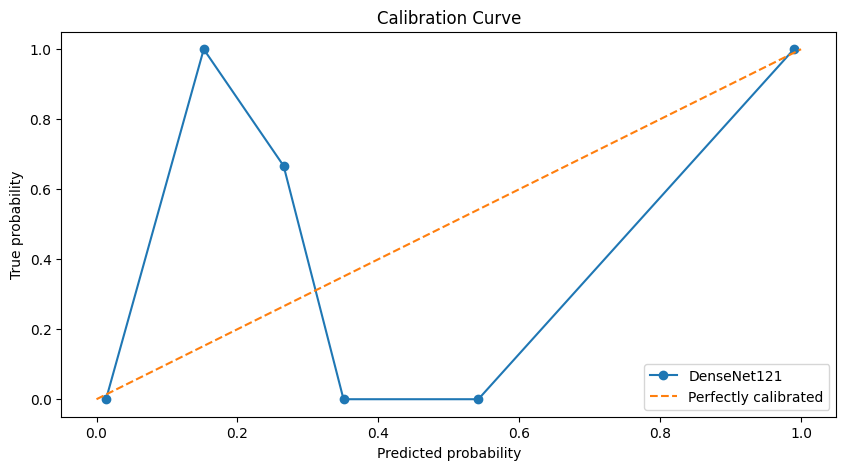

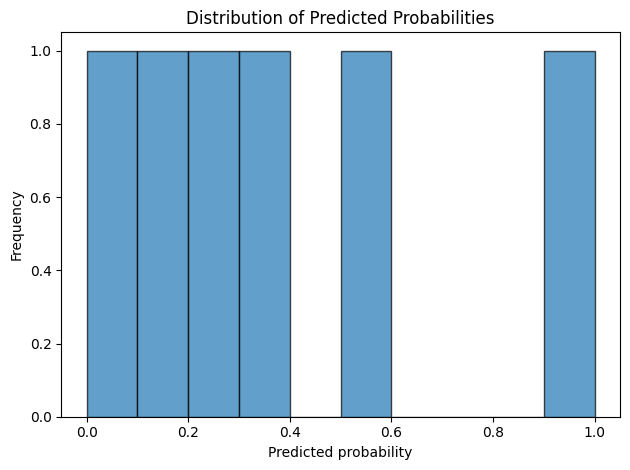

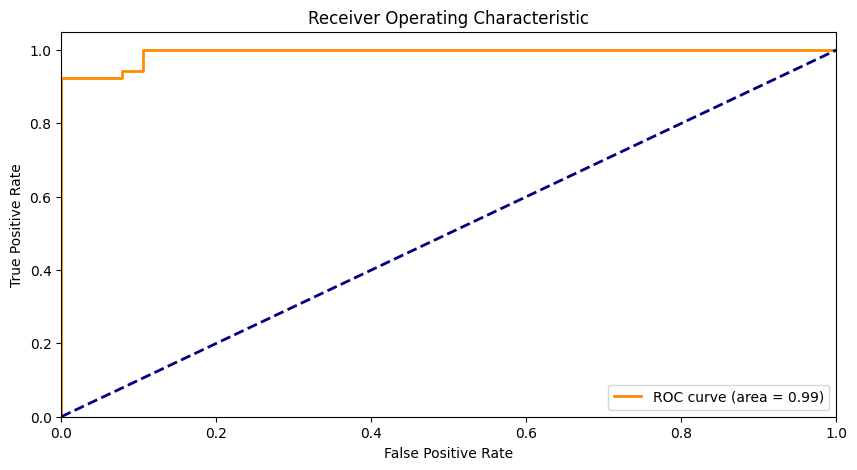

{'loss': 0.10685276345037364}

In [58]:
train_model({
    "lr": 4e-4,
    "batch_size": 12,
    "weight_decay": 1e-3,
    "mask_channel": True,
    "threshold": 0.5,
    "seg_path": 4})





In [70]:
test_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/test_dataset/**/*')])

test_seg_paths_multibin = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/Best_final_masks/Best_model_test/*')])
test_paths = format_test_file_paths(test_seg_paths_multibin, test_paths)

print(f"Test length: {len(test_paths)}")
hand_crafted_features_test_df = pd.read_csv('test_features_normalised.csv')
test_dataset = MycetomaDataset(test_paths, DATA_DIR, hand_crafted_features_test_df, mask_channel=True, test=True)

test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

# model = DenseNet169(
#     spatial_dims=2,
#     in_channels=3,
#     out_channels=1,
#     pretrained=True)
model = CustomDenseNet(in_channels=4, num_handcrafted_features=27)
model.load_state_dict(torch.load(r"C:\Users\mm17b2k.DS\DataspellProjects\MICCAI\classifier_model_sub1_2_1.pt"))

# Submission 1 (new4)
# "lr": 4e-4,
# "batch_size": 12,
# "weight_decay": 1e-3,
# "mask_channel": True,
# "threshold": 0.5,
# "seg_path": 4})

#Epoch [23/30], Train Loss: 0.0917, Train Accuracy: 0.9747, Train AUC: 0.9747, Sensitivity: 0.9743, Specificity: 0.9752 MCC: 0.9493
# Train Confusion Matrix:
# [[275   7]
#  [  8 303]]
# Test Loss: 0.0790, Test Accuracy: 0.9670, Test AUC: 0.9680 Sensitivity: 0.9623, Specificity: 0.9737 MCC: 0.9327
# Test Confusion Matrix:
# [[37  1]
#  [ 2 51]]


# Submission 2
#model.load_state_dict(torch.load(r"C:\Users\mm17b2k.DS\DataspellProjects\MICCAI\classifier_model_best_1_1.pt"))
# "lr": 4e-4,
# "batch_size": 12,
# "weight_decay": 1e-3,
# "mask_channel": False,
# "threshold": 0.5,
# "seg_path": 2
# Epoch [5/25], Train Loss: 0.0429, Train Accuracy: 0.9916, Train AUC: 0.9916, Sensitivity: 0.9904, Specificity: 0.9929 MCC: 0.9831
# Train Confusion Matrix:
# [[280   2]
#  [  3 308]]
# Test Loss: 0.0636, Test Accuracy: 0.9780, Test AUC: 0.9774 Sensitivity: 0.9811, Specificity: 0.9737 MCC: 0.9548
# Test Confusion Matrix:
# [[37  1]
#  [ 1 52]]

model = model.to(device)
model.eval()

use_handcrafted = True
threshold = 0.5
all_test_preds = []
all_test_probs = []
with torch.no_grad():
    for features, hand_crafted_features in test_loader:
        features = features.to(device)
        hand_crafted_features = hand_crafted_features.to(device)
        if use_handcrafted:
            output = model(features, hand_crafted_features.float())  # Remove batch dimension
        else:
            output = model(features)
        output = output.squeeze(1)

        # Store predictions and labels
        #predicted_probs = F.softmax(output, dim=1)[:, 1]  # Probability of class 1 (positive)
        predicted_probs = torch.sigmoid(output)
        predicted_class = (predicted_probs >= threshold).long()
        all_test_preds.extend(predicted_class.cpu().numpy())
        all_test_probs.extend(predicted_probs.cpu().numpy())
        
print(all_test_probs)
print(all_test_preds)



Test length: 167
[0.9995926, 0.005916398, 0.99968493, 0.99987745, 0.9993426, 0.9996458, 0.9998603, 0.0039799064, 0.9999094, 0.99963033, 0.9839188, 0.66247165, 0.7842286, 0.9995926, 0.0734145, 0.16825606, 0.993493, 0.9448285, 0.10862803, 2.2456955e-07, 0.8383626, 0.9440794, 0.00857989, 0.025246372, 0.05788131, 0.99415165, 0.019724185, 0.00046344326, 0.010279968, 0.0017012666, 0.984475, 0.00515339, 0.999703, 0.023168428, 0.9955851, 0.00046344326, 0.9940077, 0.9870682, 1.0, 0.014158037, 0.93985033, 0.99950385, 0.96401036, 0.9048282, 0.0039828825, 0.5024433, 0.99892646, 0.00993171, 0.99856, 0.27093035, 0.0007221568, 0.5112668, 0.99316883, 0.9995634, 0.029566338, 0.999948, 0.015530703, 0.9986594, 0.0065929405, 0.9999994, 0.005916398, 0.99661946, 0.9855041, 0.053477056, 0.009161629, 0.98672664, 0.9898421, 0.84601486, 0.004077882, 0.019240566, 0.9977749, 0.9461675, 0.00023754829, 0.99993086, 0.9976891, 0.0021036782, 0.9885577, 0.023168428, 0.99927145, 0.9779514, 0.0071527753, 0.99661946, 0.02

In [72]:
new5 = [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]
new4 = [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0]
new3 = [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]
new2= [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]
new = [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]
old = [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
print(accuracy_score(new, new5))

0.9640718562874252


In [74]:
# load excel 
import pandas as pd
df1 = pd.read_excel(r"C:\Users\mm17b2k.DS\DataspellProjects\MICCAI\classification_labels_sub1.xlsx")
df2 = pd.read_excel(r"C:\Users\mm17b2k.DS\DataspellProjects\MICCAI\classification_labels_sub2.xlsx")
# compare the two
print(accuracy_score(df1['Prediction'], df2['Prediction']))

0.9640718562874252


In [71]:
test_file_names = [i[0].split('\\')[-1] for i in test_paths]
# combine all_test_preds and test_file_names in dictionary
test_preds_dict = dict(zip(test_file_names, all_test_preds))
# save to excel
df = pd.DataFrame(list(test_preds_dict.items()),columns = ['Filename','Prediction'])
df['Prediction'] = df['Prediction'].apply(lambda x: 'BM' if x == 0 else 'FM')
df.to_excel(r"C:\Users\mm17b2k.DS\DataspellProjects\MICCAI\submission1.xlsx", index = False)
df





,Filename,Prediction
0,100P.jpg,FM
1,10A.jpg,BM
2,10I.jpg,FM
3,11O.jpg,FM
4,11Y.jpg,FM
...,...,...
162,98B.jpg,BM
163,98I.jpg,FM
164,98P.jpg,BM
165,99H.jpg,FM


In [75]:
#sub 1
for i, pred in enumerate(all_test_probs):
    if 0.25 <= pred <= 0.75:
        print(i, pred)
        print(test_paths[i])

11 0.66247165
['C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_dataset\\15Q.jpg', 'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/Best_final_masks/Best_model_test\\15Q_mask.tif']
45 0.5024433
['C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_dataset\\2L.jpg', 'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/Best_final_masks/Best_model_test\\2L_mask.tif']
49 0.27093035
['C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_dataset\\30C.jpg', 'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/Best_final_masks/Best_model_test\\30C_mask.tif']
51 0.5112668
['C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_dataset\\34W.jpg', 'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/Best_final_masks/Best_model_test\\34W_mask.tif']
96 0.66340286
['C:\\Users\\mm17b2k.DS\\DataspellProj

In [32]:
#sub 2
for i, pred in enumerate(all_test_probs):
    if 0.25 <= pred <= 0.75:
        print(i, pred)
        print(test_paths[i])

17 0.53587073
49 0.54537594
93 0.69805086
95 0.30696112
142 0.3519051
151 0.31064788
161 0.64306486
162 0.29838234


In [16]:
test_paths[142]

'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_dataset\\87J.jpg'

In [4]:
import numpy as np
import glob
DATA_DIR = r"C:\Users\mm17b2k.DS\DataspellProjects\MICCAI\Mycetoma Dataset"
test_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/test_dataset/**/*')])
test_paths

array(['C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_dataset\\100P.jpg',
       'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_dataset\\10A.jpg',
       'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_dataset\\10I.jpg',
       'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_dataset\\11O.jpg',
       'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_dataset\\11Y.jpg',
       'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_dataset\\12J.jpg',
       'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_dataset\\13O.jpg',
       'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_dataset\\14D.jpg',
       'C:\\Users\\mm17b2k.DS\\DataspellProjects\\MICCAI\\Mycetoma Dataset/test_dataset\\test_d